In [1]:
import json
import os
import pandas as pd
import numpy as np
from pathlib import Path
from PIL.ImageChops import constant
from Scripts.pywin32_testall import project_root
from scipy.stats import obrientransform
import sys
from matplotlib import pyplot as plt
from pathlib import Path
project_root = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path().resolve().parent
sys.path.append(str(project_root))
from src.utils.eda_utils import missingness,summarize

In [2]:
Root_dir = Path.cwd().parent
data_dir = Path(Root_dir.joinpath('data/raw/tlc/yellow/2023'))
zone_path = Path(Root_dir.joinpath('data/raw/tlc/misc/taxi_zone_lookup.csv'))
file_1 = Path(data_dir.joinpath('yellow_tripdata_2023-01.parquet'))

In [3]:
df = pd.read_parquet(file_1)

In [4]:
numeric_all = df.select_dtypes(include="number").columns.tolist()
exclude_ids = [c for c in ["VendorID","RatecodeID","PULocationID","DOLocationID","payment_type","trip_type"]
               if c in df.columns]
cols = [c for c in numeric_all if c not in exclude_ids]

In [5]:
print(f"Numeric columns selected: {len(cols)} (excluded IDs: {len(exclude_ids)})")

Numeric columns selected: 11 (excluded IDs: 5)


In [6]:
num_sum = summarize(df, cols)

In [7]:
out_path = Root_dir / "reports" / "tables" / "num_summary.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)
num_sum.sort_values("name").to_csv(out_path, index=False)

In [8]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN


In [31]:
plot_distance = df['trip_distance'].dropna().astype(float)
n = len(plot_distance)
q25 , q75 = np.percentile(plot_distance, [25, 75])
iqr = float(q75 - q25)
h = float (2 * iqr * (n ** (-1/3)))
lo = q25 - 1.5*iqr
hi = q75 + 1.5*iqr

In [25]:
p1, p99 = np.percentile(plot_distance, [1, 99])
if not np.isfinite(p1) or not np.isfinite(p99) or p99 <= p1:
    p1, p99 = float(plot_distance.min()), float(plot_distance.max())

In [26]:
if iqr <= 0 or h <= 0:
    bins = int(np.ceil(1 + np.log2(plot_distance)))
else:
    bins = int(np.ceil((p99 - p1) / h))
bins = max(10, min(bins, 200))

In [28]:
fig_dir = Root_dir / "reports" / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)
png_linear = fig_dir / "hist_trip_distance_fd.png"
png_logx  = fig_dir / "hist_trip_distance_fd_logx.png"
fig_dir

WindowsPath('D:/Portfolio/eda-portfolio/reports/figures')

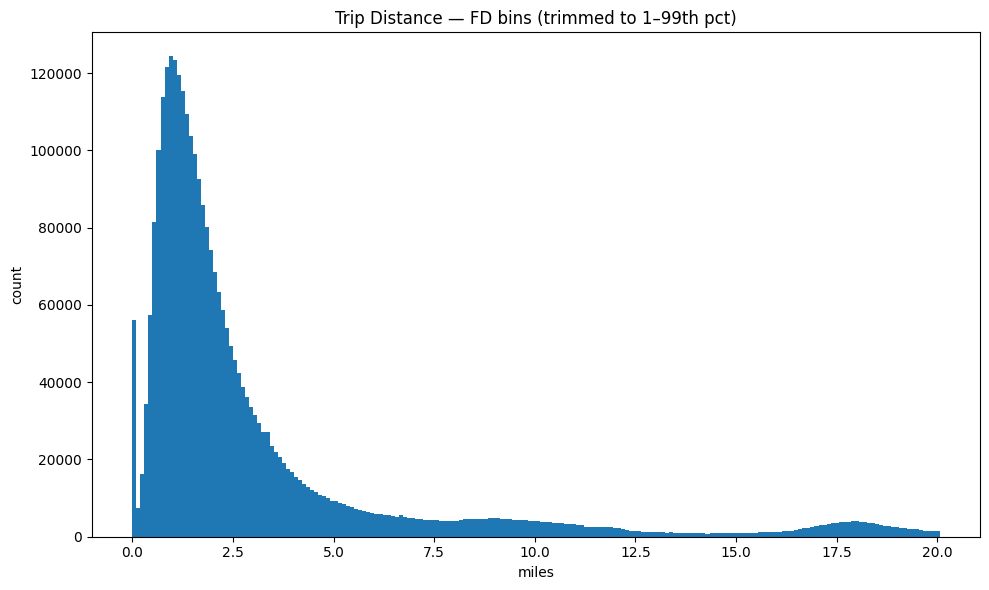

In [29]:
plt.figure(figsize=(10, 6))
plt.hist(plot_distance, bins=bins, range=(p1, p99))
plt.title("Trip Distance — FD bins (trimmed to 1–99th pct)")
plt.xlabel("miles")
plt.ylabel("count")
plt.tight_layout()
plt.savefig(png_linear, dpi=120)
plt.show()

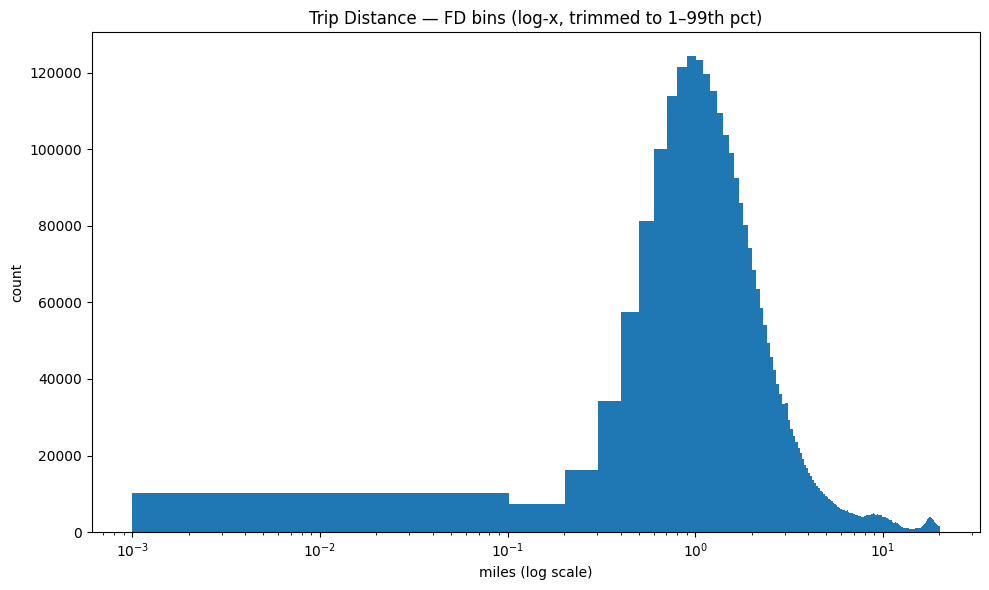

In [30]:
p1_log = max(p1, 1e-3)
plt.figure(figsize=(10, 6))
plt.hist(plot_distance, bins=bins, range=(p1_log, p99))
plt.xscale("log")
plt.title("Trip Distance — FD bins (log-x, trimmed to 1–99th pct)")
plt.xlabel("miles (log scale)")
plt.ylabel("count")
plt.tight_layout()
plt.savefig(png_logx, dpi=120)
plt.show()

In [33]:
(plot_distance < lo | plot_distance > hi)

TypeError: Cannot perform 'ror_' with a dtyped [float64] array and scalar of type [bool]